# Subtype predictor -- single cell QC

In this file I will QC the HGSC single cell data from 

cell type calls are from the authors

data is from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE154600


manuscript of data: Multi-omic analysis of subtype evolution and heterogeneity in high-grade serous ovarian carcinoma


I will make the typical QC plots, then write it out for making pseudobulks

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from matplotlib.pyplot import rc_context

import os

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

data_path = f"{os.getcwd()}/../../data/single_cell/"

result_ad_file = f"{data_path}/GSE154600_processed/GSE154600_processed.h5ad"


2025-01-07 19:24:44.811097: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-07 19:24:44.811800: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-07 19:24:44.813616: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-07 19:24:44.818675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736303084.826840 2355973 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736303084.82

scanpy==1.10.4 anndata==0.8.0 umap==0.5.2 numpy==1.26.0 scipy==1.14.1 pandas==1.5.3 scikit-learn==1.6.0 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13


In [2]:
# read in the expression
all_samps = ["GSM4675273", "GSM4675274", "GSM4675275", 
               "GSM4675276", "GSM4675277"]

all_adata = None
for curr_samp in all_samps:
    adata_0 = sc.read_10x_mtx(f"{data_path}/GSE154600_RAW/{curr_samp}")
    adata_0.obs["GSM"] = curr_samp
    if all_adata is None:
        all_adata = adata_0
    else:
        all_adata = ad.concat([all_adata, adata_0])

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# format metadata

In [3]:
# read in the metadata
meta_cell_path = f"{data_path}/GSE154600_metadata/GSE154600_cell_metadata.csv"
meta_samp_path = f"{data_path}/GSE154600_metadata/GSE154600_sample_metadata.csv"

# read in tables
meta_cell_df = pd.read_csv(meta_cell_path)
meta_samp_df = pd.read_csv(meta_samp_path)


# format the subtype metadata
meta_cell_df["max_consensusOV"]=meta_cell_df[["IMR_consensus", "DIF_consensus", "PRO_consensus", "MES_consensus"]].max(axis=1) 

# merge the metadata
meta_cell_df.index = meta_cell_df["Barcode"]
merged_df = all_adata.obs.join(meta_cell_df, how='inner')
merged_df = pd.merge(merged_df, meta_samp_df, left_on='samp_id', right_on='samp_id')

# remove duplicates
cell_barcode_keep = pd.Series(merged_df["Barcode"]).drop_duplicates(keep=False)
merged_df = merged_df.iloc[np.where(merged_df["Barcode"].isin(cell_barcode_keep))[0]]
all_adata = all_adata[np.where(all_adata.obs.index.isin(cell_barcode_keep))[0],:]

# order the obs in the same order
merged_df.index = merged_df["Barcode"]
left_df, right_df = merged_df.align(all_adata.obs, join="inner", axis=0)
left_df

merged_df.index = merged_df["Barcode"]

#inner: use intersection of keys from both frames, preserve the order of the left keys.
left_df, right_df = all_adata.obs.align(merged_df, join="inner", axis=0)

# now keeping the same ordering as the original obs
# replace the obs DF
all_adata = all_adata[left_df.index, :]
all_adata.obs = right_df


In [4]:
all_adata.obs

GSM             Barcode  Cluster cellType  \
AAACCTGAGCTGCCCA-1  GSM4675273  AAACCTGAGCTGCCCA-1        3      MYE   
AAACCTGCAAGCCCAC-1  GSM4675273  AAACCTGCAAGCCCAC-1        3      MYE   
AAACCTGCAAGCGCTC-1  GSM4675273  AAACCTGCAAGCGCTC-1        5      EPI   
AAACCTGCACGTAAGG-1  GSM4675273  AAACCTGCACGTAAGG-1        5      EPI   
AAACCTGCACGTGAGA-1  GSM4675273  AAACCTGCACGTGAGA-1        3      MYE   
...                        ...                 ...      ...      ...   
TTTGTCACACAGCCCA-1  GSM4675277  TTTGTCACACAGCCCA-1        4    LYMPH   
TTTGTCACATTCTTAC-1  GSM4675277  TTTGTCACATTCTTAC-1        5      EPI   
TTTGTCAGTAGCTGCC-1  GSM4675277  TTTGTCAGTAGCTGCC-1        6    STROM   
TTTGTCAGTTGAGGTG-1  GSM4675277  TTTGTCAGTTGAGGTG-1        6    STROM   
TTTGTCATCTGTGCAA-1  GSM4675277  TTTGTCATCTGTGCAA-1        4    LYMPH   

                        hpca_celltype   encode_celltype subtype  \
AAACCTGAGCTGCCCA-1         Macrophage       Macrophages     DIF   
AAACCTGCAAGCCCAC-1         Macrophage       Macrophages     IMR   
AAACCTGCAAGCGCTC-1   Epithelial_cells  Epithelial cells     DIF   
AAACCTGCACGTAAGG-1   Epithelial_cells  Epithelial cells     DIF   
AAACCTGCACGTGAGA-1         Macrophage         Monocytes     DIF   
...                               ...               ...     ...   
TTTGTCACACAGCCCA-1            T_cells      CD8+ T-cells     DIF   
TTTGTCACATTCTTAC-1          iPS_cells  Epithelial cells     DIF   
TTTGTCAGTAGCTGCC-1        Fibroblasts       Fibroblasts     MES   
TTTGTCAGTTGAGGTG-1  Tissue_stem_cells        Astrocytes     MES   
TTTGTCATCTGTGCAA-1            T_cells      CD8+ T-cells     DIF   

                    IMR_consensus  DIF_consensus  PRO_consensus  \
AAACCTGAGCTGCCCA-1          0.322          0.334          0.158   
AAACCTGCAAGCCCAC-1          0.362          0.248          0.142   
AAACCTGCAAGCGCTC-1          0.228          0.346          0.266   
AAACCTGCACGTAAGG-1          0.176          0.494          0.258   
AAACCTGCACGTGAGA-1          0.256          0.304          0.192   
...                           ...            ...            ...   
TTTGTCACACAGCCCA-1          0.236          0.468          0.160   
TTTGTCACATTCTTAC-1          0.062          0.412          0.484   
TTTGTCAGTAGCTGCC-1          0.106          0.236          0.300   
TTTGTCAGTTGAGGTG-1          0.066          0.118          0.288   
TTTGTCATCTGTGCAA-1          0.166          0.484          0.172   

                    MES_consensus samp_id  max_consensusOV      geo_id  \
AAACCTGAGCTGCCCA-1          0.186     T59            0.334  GSM4675273   
AAACCTGCAAGCCCAC-1          0.248     T59            0.362  GSM4675273   
AAACCTGCAAGCGCTC-1          0.160     T59            0.346  GSM4675273   
AAACCTGCACGTAAGG-1          0.072     T59            0.494  GSM4675273   
AAACCTGCACGTGAGA-1          0.248     T59            0.304  GSM4675273   
...                           ...     ...              ...         ...   
TTTGTCACACAGCCCA-1          0.136     T90            0.468  GSM4675277   
TTTGTCACATTCTTAC-1          0.042     T90            0.484  GSM4675277   
TTTGTCAGTAGCTGCC-1          0.358     T90            0.358  GSM4675277   
TTTGTCAGTTGAGGTG-1          0.528     T90            0.528  GSM4675277   
TTTGTCATCTGTGCAA-1          0.178     T90            0.484  GSM4675277   

                     tissue diagnosis stage  grade chemo_response  
AAACCTGAGCTGCCCA-1  omentum      HGSC    IV      3      resistant  
AAACCTGCAAGCCCAC-1  omentum      HGSC    IV      3      resistant  
AAACCTGCAAGCGCTC-1  omentum      HGSC    IV      3      resistant  
AAACCTGCACGTAAGG-1  omentum      HGSC    IV      3      resistant  
AAACCTGCACGTGAGA-1  omentum      HGSC    IV      3      resistant  
...                     ...       ...   ...    ...            ...  
TTTGTCACACAGCCCA-1  omentum      HGSC   IVa      3      sensitive  
TTTGTCACATTCTTAC-1  omentum      HGSC   IVa      3      sensitive  
TTTGTCAGTAGCTGCC-1  omentum      HGSC   IVa      3 

In [5]:
all_adata.obs.encode_celltype.value_counts()

CD8+ T-cells         8601
Fibroblasts          4697
Adipocytes           4354
Macrophages          4214
Epithelial cells     4199
Mesangial cells      3781
Monocytes            3614
CD4+ T-cells         1547
NK cells             1508
B-cells              1303
HSC                  1012
Endothelial cells     581
Erythrocytes          476
DC                    154
Keratinocytes          24
Myocytes               21
Skeletal muscle        21
Astrocytes             10
Pericytes               7
Chondrocytes            5
Name: encode_celltype, dtype: int64

In [6]:
# remove low count cells 
ct_idx = all_adata.obs.encode_celltype.isin(["HSC", "DC", "Erythrocytes", "Keratinocytes",
                                             "Myocytes", "Astrocytes", "Pericytes", "Chondrocytes",
                                             "Skeletal muscle"])
inverted_list = [not x for x in ct_idx]
all_adata = all_adata[np.where(inverted_list)[0]]

tab = all_adata.obs.groupby(['encode_celltype', 'GSM']).size()
tab.unstack()

GSM                GSM4675273  GSM4675274  GSM4675275  GSM4675276  GSM4675277
encode_celltype                                                              
Adipocytes                947        2936         298         129          44
B-cells                   193          69         306         548         187
CD4+ T-cells              586         125         196         294         346
CD8+ T-cells             1677        2527        1493        1545        1359
Endothelial cells          75         352          35          87          32
Epithelial cells         2630          66         472         242         789
Fibroblasts               376        3820          39         289         173
Macrophages              2375         665         557         474         143
Mesangial cells          1206         734        1782          15          44
Monocytes                1636         980         101         739         158
NK cells                  406         658         128         227          89

In [7]:
# format metadata

# reformat the cell types to be more granular
cell_type_vec = all_adata.obs['encode_celltype'].copy()
immune_idx = np.where(cell_type_vec.isin(["CD8+ T-cells", "Macrophages", "Monocytes", 
                                          "NK cells", "CD4+ T-cells", "B-cells"]) )[0] ### START HERE
cell_type_vec[immune_idx] = "immune"

stromal_idx = np.where(cell_type_vec.isin(["Endothelial cells", "Adipocytes", "Mesangial cells",
                                           "Fibroblasts"]) )[0]
cell_type_vec[stromal_idx] = "stromal"

epi_idx = np.where(cell_type_vec.isin(["Epithelial cells"]) )[0]
cell_type_vec[epi_idx] = "tumor"
all_adata.obs['celltype_granular'] = cell_type_vec

all_adata.obs['scpred_CellType'] = all_adata.obs['encode_celltype']
all_adata.obs['orig_celltype'] = all_adata.obs['cellType']
all_adata.obs['cellType'] = all_adata.obs['encode_celltype']

# remove cells with no cell type
all_adata = all_adata[np.where(~all_adata.obs.scpred_CellType.isna())[0]]

all_adata.obs['sample_id'] = 'Samp_' + all_adata.obs['samp_id'].astype(str)
all_adata.obs['sample_id'] = all_adata.obs['sample_id'].tolist()
all_adata.obs['stim'] = ["CTRL"]*len(all_adata.obs)


/tmp/ipykernel_2355973/917234612.py:15: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  all_adata.obs['celltype_granular'] = cell_type_vec
/tmp/ipykernel_2355973/917234612.py:24: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  all_adata.obs['sample_id'] = 'Samp_' + all_adata.obs['samp_id'].astype(str)


In [8]:
set(all_adata.obs.scpred_CellType)

{'Adipocytes',
 'B-cells',
 'CD4+ T-cells',
 'CD8+ T-cells',
 'Endothelial cells',
 'Epithelial cells',
 'Fibroblasts',
 'Macrophages',
 'Mesangial cells',
 'Monocytes',
 'NK cells'}

In [9]:
tab = all_adata.obs.groupby(['encode_celltype', 'sample_id']).size()
tab.unstack()

sample_id          Samp_T59  Samp_T76  Samp_T77  Samp_T89  Samp_T90
encode_celltype                                                    
Adipocytes              947      2936       298       129        44
B-cells                 193        69       306       548       187
CD4+ T-cells            586       125       196       294       346
CD8+ T-cells           1677      2527      1493      1545      1359
Endothelial cells        75       352        35        87        32
Epithelial cells       2630        66       472       242       789
Fibroblasts             376      3820        39       289       173
Macrophages            2375       665       557       474       143
Mesangial cells        1206       734      1782        15        44
Monocytes              1636       980       101       739       158
NK cells                406       658       128       227        89

In [10]:
tab = all_adata.obs.iloc[np.where(all_adata.obs.scpred_CellType == "Epithelial cells")[0]].groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype       DIF  IMR  MES    PRO
sample_id                         
Samp_T59   2298.0  6.0  2.0  324.0
Samp_T76     66.0  NaN  NaN    NaN
Samp_T77    387.0  NaN  4.0   81.0
Samp_T89    224.0  NaN  NaN   18.0
Samp_T90    704.0  NaN  NaN   85.0

In [11]:
tab = all_adata.obs.groupby(['encode_celltype', 'cellType']).size()
tab.unstack()

cellType           Adipocytes  B-cells  CD4+ T-cells  CD8+ T-cells  \
encode_celltype                                                      
Adipocytes             4354.0      NaN           NaN           NaN   
B-cells                   NaN   1303.0           NaN           NaN   
CD4+ T-cells              NaN      NaN        1547.0           NaN   
CD8+ T-cells              NaN      NaN           NaN        8601.0   
Endothelial cells         NaN      NaN           NaN           NaN   
Epithelial cells          NaN      NaN           NaN           NaN   
Fibroblasts               NaN      NaN           NaN           NaN   
Macrophages               NaN      NaN           NaN           NaN   
Mesangial cells           NaN      NaN           NaN           NaN   
Monocytes                 NaN      NaN           NaN           NaN   
NK cells                  NaN      NaN           NaN           NaN   

cellType           Endothelial cells  Epithelial cells  Fibroblasts  \
encode_celltype                                                       
Adipocytes                       NaN               NaN          NaN   
B-cells                          NaN               NaN          NaN   
CD4+ T-cells                     NaN               NaN          NaN   
CD8+ T-cells                     NaN               NaN          NaN   
Endothelial cells              581.0               NaN          NaN   
Epithelial cells                 NaN            4199.0          NaN   
Fibroblasts                      NaN               NaN       4697.0   
Macrophages                      NaN               NaN          NaN   
Mesangial cells                  NaN               NaN          NaN   
Monocytes                        NaN               NaN          NaN   
NK cells                         NaN               NaN          NaN   

cellType           Macrophages  Mesangial cells  Monocytes  NK cells  
encode_celltype                                                       
Adipocytes                 NaN              NaN        NaN       NaN  
B-cells                    NaN              NaN        NaN       NaN  
CD4+ T-cells               NaN              NaN        NaN       NaN  
CD8+ T-cells               NaN              NaN        NaN       NaN  
Endothelial cells          NaN              NaN        NaN       NaN  
Epithelial cells           NaN              NaN        NaN       NaN  
Fibroblasts                NaN              NaN        NaN       NaN  
Macrophages             4214.0              NaN        NaN       NaN  
Mesangial cells            NaN           3781.0        NaN       NaN  
Monocytes                  NaN              NaN     3614.0       NaN  
NK cells                   NaN              NaN        NaN    1508.0

In [12]:
tab = all_adata.obs.groupby(['encode_celltype', 'subtype']).size()
tab.unstack()

subtype               DIF     IMR     MES    PRO
encode_celltype                                 
Adipocytes         2683.0   298.0  1251.0  122.0
B-cells            1247.0    39.0     6.0   11.0
CD4+ T-cells       1478.0    48.0     8.0   13.0
CD8+ T-cells       8283.0   266.0    23.0   29.0
Endothelial cells   482.0    10.0    16.0   73.0
Epithelial cells   3679.0     6.0     6.0  508.0
Fibroblasts        1979.0   177.0  2384.0  157.0
Macrophages        2440.0  1680.0    72.0   22.0
Mesangial cells    2544.0    34.0   544.0  659.0
Monocytes          2371.0  1183.0    41.0   19.0
NK cells           1432.0    70.0     NaN    6.0

In [13]:
tab = all_adata.obs.groupby(['celltype_granular', 'subtype']).size()
tab.unstack()

subtype              DIF   IMR   MES   PRO
celltype_granular                         
immune             17251  3286   150   100
stromal             7688   519  4195  1011
tumor               3679     6     6   508

In [42]:
tab = all_adata.obs.iloc[np.where(all_adata.obs.max_consensusOV > 0.4)[0]].groupby(['celltype_granular', 'subtype']).size()
tab.unstack()

subtype              DIF   IMR   MES  PRO
celltype_granular                        
immune             12666  2242    14   21
stromal             4544   166  2501  464
tumor               3314     3     0  374

In [15]:
immune_ct = ["tumor"]

idx = np.where(all_adata.obs.celltype_granular.isin(immune_ct))[0]

tab = all_adata.obs.iloc[idx].groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype       DIF  IMR  MES    PRO
sample_id                         
Samp_T59   2298.0  6.0  2.0  324.0
Samp_T76     66.0  NaN  NaN    NaN
Samp_T77    387.0  NaN  4.0   81.0
Samp_T89    224.0  NaN  NaN   18.0
Samp_T90    704.0  NaN  NaN   85.0

In [16]:
all_adata.var.index

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.4', 'AL732372.1', 'OR4F29', 'AC114498.1',
       ...
       'AC007325.2', 'BX072566.1', 'AL354822.1', 'AC023491.2', 'AC004556.1',
       'AC233755.2', 'AC233755.1', 'AC240274.1', 'AC213203.1', 'FAM231C'],
      dtype='object', length=33538)

In [17]:
# remove genes that are duplicated
all_adata.var["gene_ids"] = all_adata.var.index.to_list()
a = (all_adata.var['gene_ids'].value_counts() == 1)
a = a[a].keys().to_list()
unique_genes = np.unique(a)

all_adata = all_adata[:, all_adata.var['gene_ids'].isin(unique_genes)]

# make the common name the index
all_adata.var.index = all_adata.var['gene_ids']


# QC everything

In [18]:
# how many of each samp
all_adata.obs["sample_id"].value_counts()

Samp_T76    12932
Samp_T59    12107
Samp_T77     5407
Samp_T89     4589
Samp_T90     3364
Name: sample_id, dtype: int64

In [19]:
# see cell types, we will merge some
tab = all_adata.obs.groupby(['scpred_CellType', 'sample_id']).size()

tab.unstack()

sample_id          Samp_T59  Samp_T76  Samp_T77  Samp_T89  Samp_T90
scpred_CellType                                                    
Adipocytes              947      2936       298       129        44
B-cells                 193        69       306       548       187
CD4+ T-cells            586       125       196       294       346
CD8+ T-cells           1677      2527      1493      1545      1359
Endothelial cells        75       352        35        87        32
Epithelial cells       2630        66       472       242       789
Fibroblasts             376      3820        39       289       173
Macrophages            2375       665       557       474       143
Mesangial cells        1206       734      1782        15        44
Monocytes              1636       980       101       739       158
NK cells                406       658       128       227        89

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


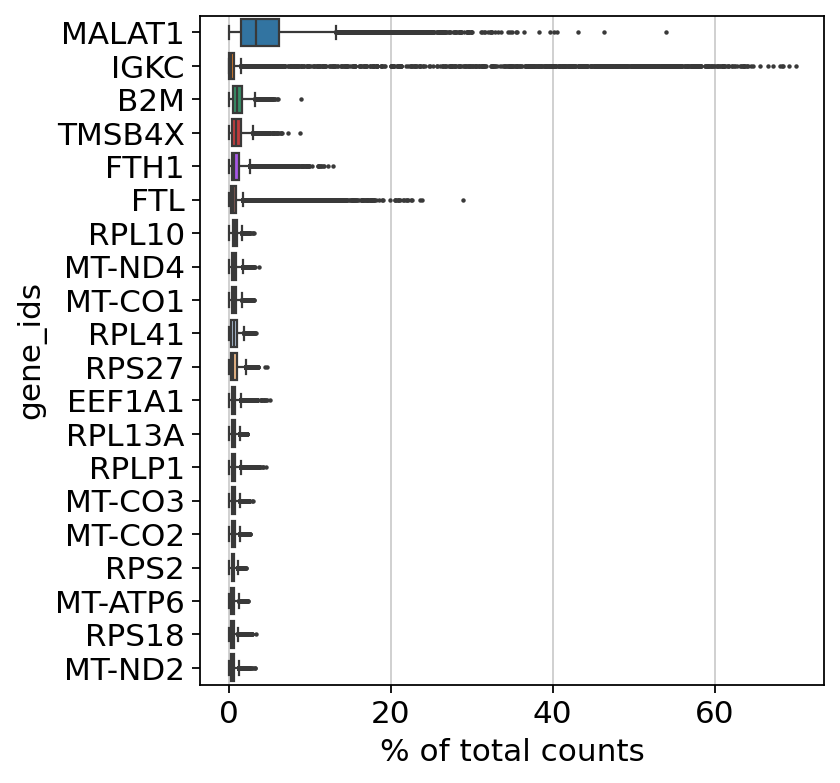

In [20]:
sc.pl.highest_expr_genes(all_adata, n_top=20, )


In [21]:
# filter out cells with less than 200 genes and genes expressed in less than 3 cells
sc.pp.filter_cells(all_adata, min_genes=500)
sc.pp.filter_genes(all_adata, min_cells=3)


filtered out 960 cells that have less than 500 genes expressed
filtered out 9018 genes that are detected in less than 3 cells


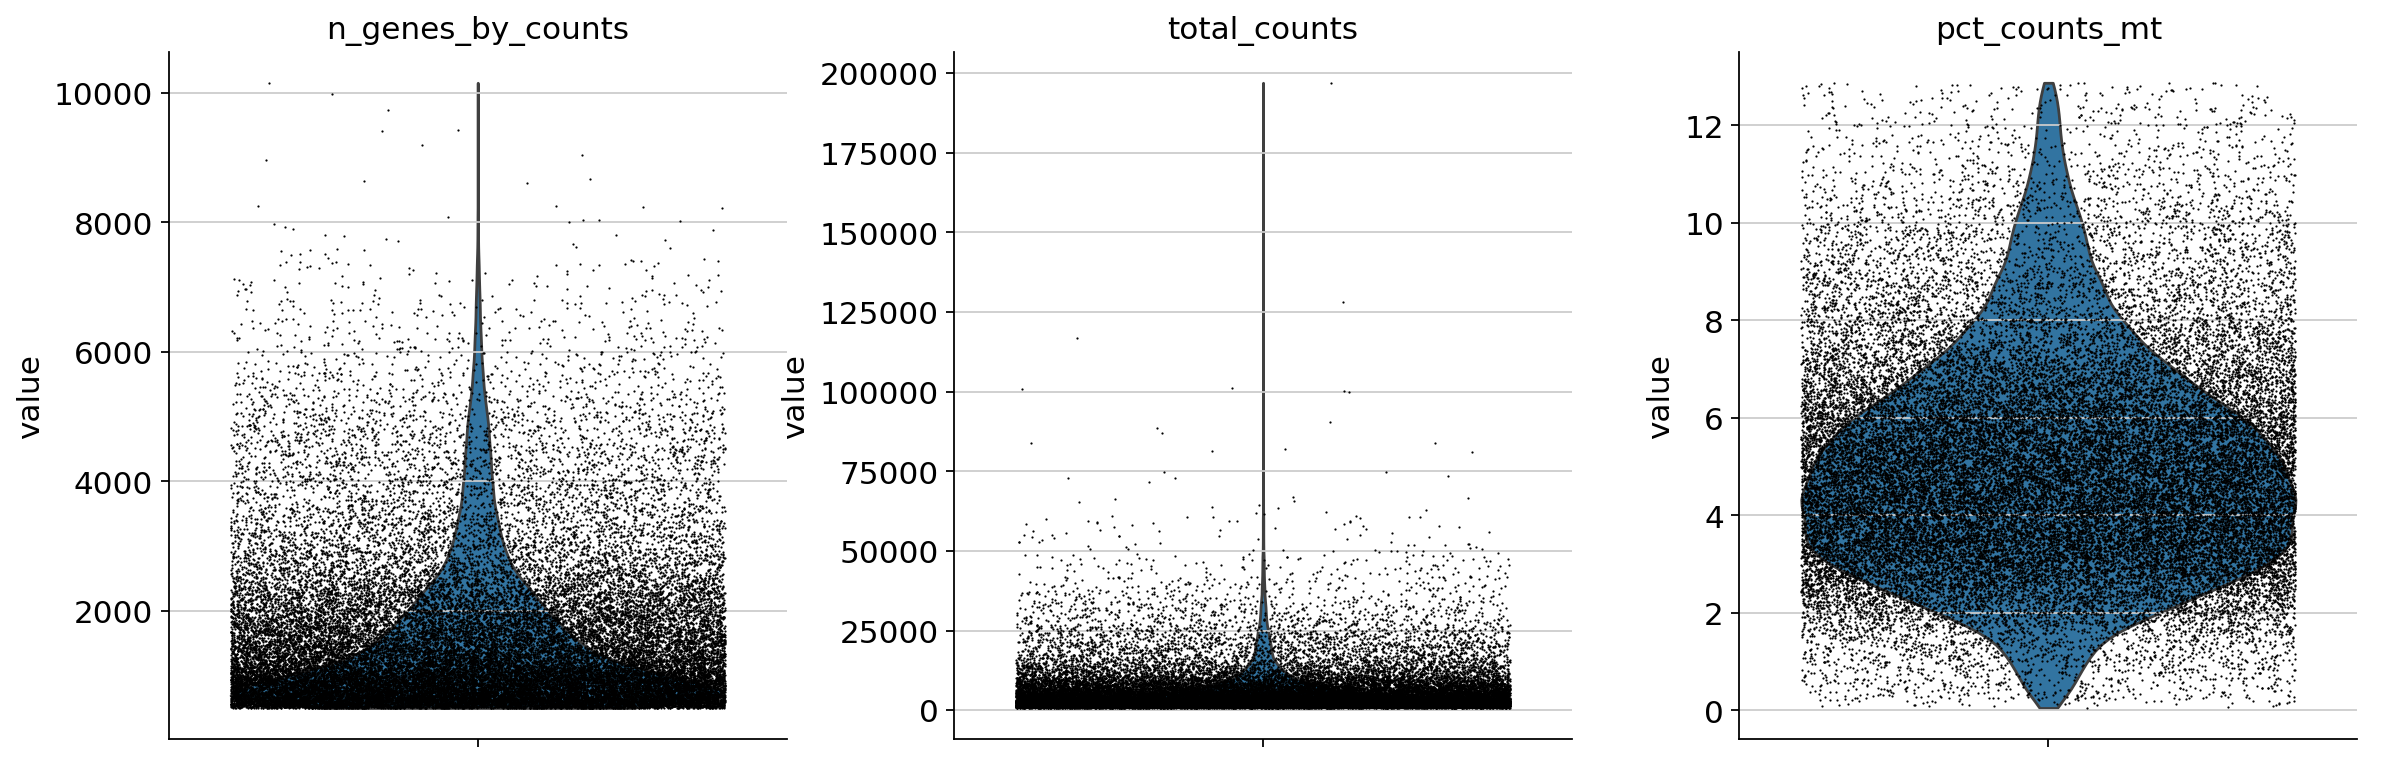

In [22]:
# remove genes with high mitochondrial content
all_adata.var['mt'] = all_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(all_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(all_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

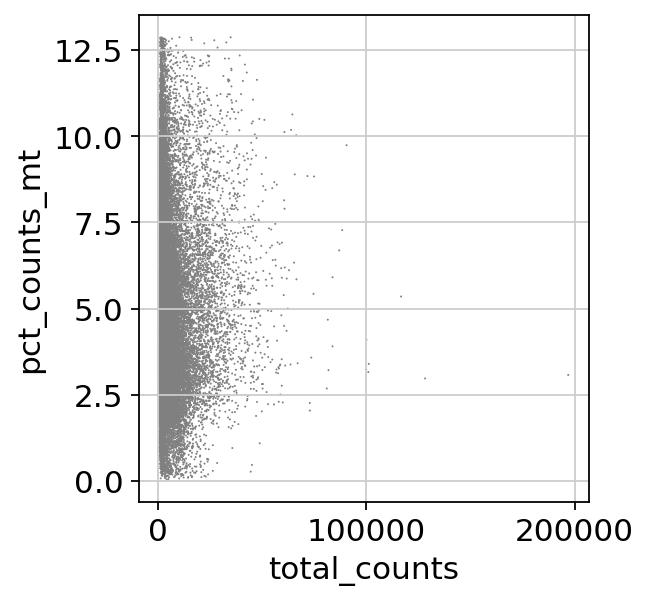

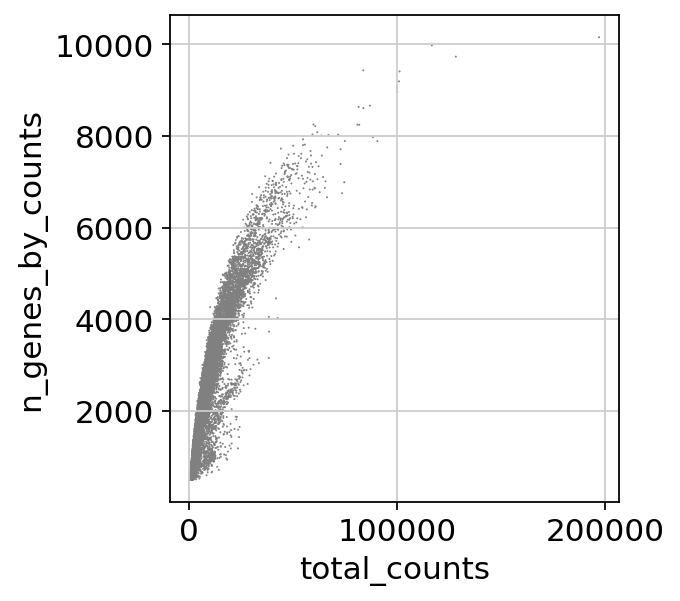

In [23]:
sc.pl.scatter(all_adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(all_adata, x='total_counts', y='n_genes_by_counts')

In [24]:
# slice the data based on the plots from above
# remove cells with more than 7000 genes
# remove cells with more than 10% MTgenes
all_adata = all_adata[all_adata.obs.n_genes_by_counts < 8000, :]
all_adata = all_adata[all_adata.obs.pct_counts_mt < 10, :]

normalizing counts per cell


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)


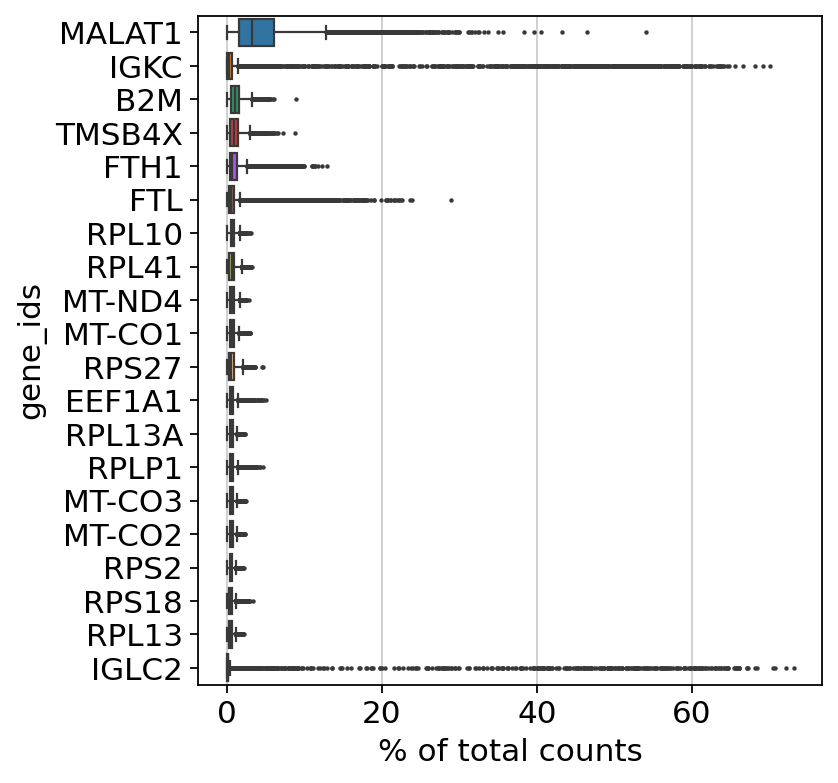

In [25]:
sc.pl.highest_expr_genes(all_adata, n_top=20, )


## write it out

In [26]:
tab = all_adata.obs.groupby(['scpred_CellType', 'sample_id']).size()
tab.unstack()

sample_id          Samp_T59  Samp_T76  Samp_T77  Samp_T89  Samp_T90
scpred_CellType                                                    
Adipocytes              925      2627       241       120        42
B-cells                 154        67       286       476       186
CD4+ T-cells            555       117       190       269       345
CD8+ T-cells           1542      2406      1452      1430      1353
Endothelial cells        73       318        31        87        30
Epithelial cells       2587        49       434       222       729
Fibroblasts             373      3522        37       284       169
Macrophages            2321       617       444       456       141
Mesangial cells        1175       606      1651        13        43
Monocytes              1606       929        88       729       155
NK cells                378       618       120       205        88

In [27]:
set(all_adata.obs.cellType)

{'Adipocytes',
 'B-cells',
 'CD4+ T-cells',
 'CD8+ T-cells',
 'Endothelial cells',
 'Epithelial cells',
 'Fibroblasts',
 'Macrophages',
 'Mesangial cells',
 'Monocytes',
 'NK cells'}

In [28]:
result_ad_file

'/var/projects/proportion_subtype_predictor/code/0_process_sc/../../data/single_cell//GSE154600_processed/GSE154600_processed.h5ad'

In [29]:
# write it out before normalization
all_adata.write(result_ad_file)


# Normalization

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


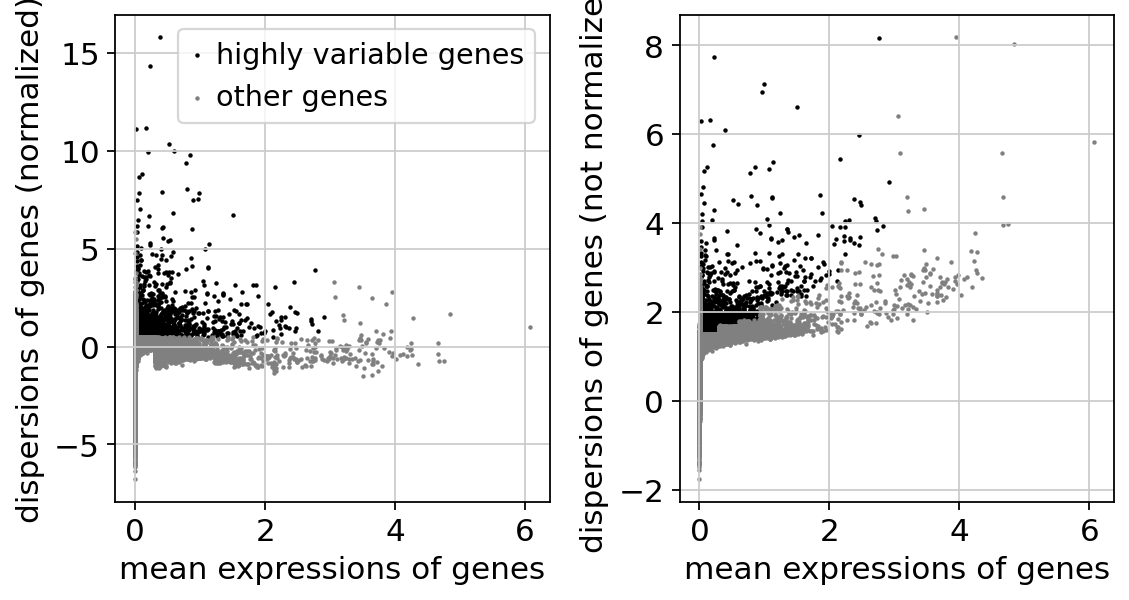

In [30]:
# normalize to 10K counts per cell
sc.pp.normalize_total(all_adata, target_sum=1e4)

# log data
sc.pp.log1p(all_adata)

# get high variance genes
sc.pp.highly_variable_genes(all_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# and plot
sc.pl.highly_variable_genes(all_adata)

# now store the raw version of the data for our use later
all_adata.raw = all_adata


In [31]:
# now process the counts further for doing DE 
# analysis and the cell clustering
all_adata = all_adata[:, all_adata.var.highly_variable]

# regress out the signal
sc.pp.regress_out(all_adata, ['total_counts', 'pct_counts_mt'])

# scale the genes
sc.pp.scale(all_adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:672: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:55)


# PCA

computing PCA
    with n_comps=50


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:210: UserWarning: When using a mask parameter with anndata<0.9 on a dense array, the PCAcan have slightly different results due the array being column major instead of row major.
  warnings.warn(


    finished (0:00:07)


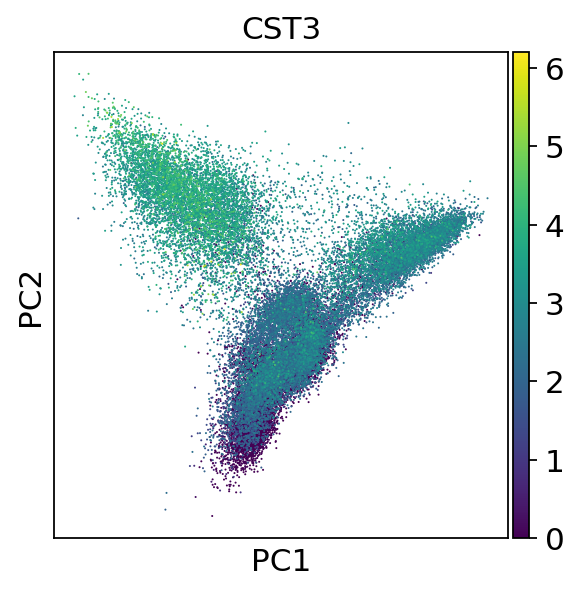

In [32]:
sc.tl.pca(all_adata, n_comps=50)
sc.pl.pca(all_adata, color='CST3')


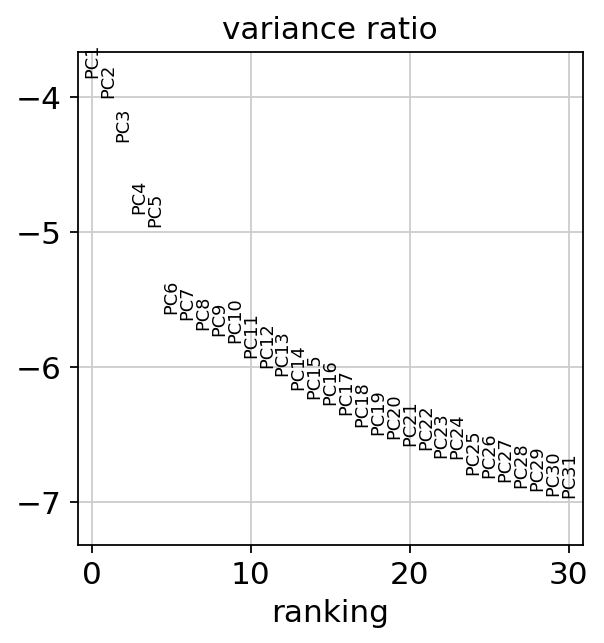

In [33]:
sc.pl.pca_variance_ratio(all_adata, log=True)


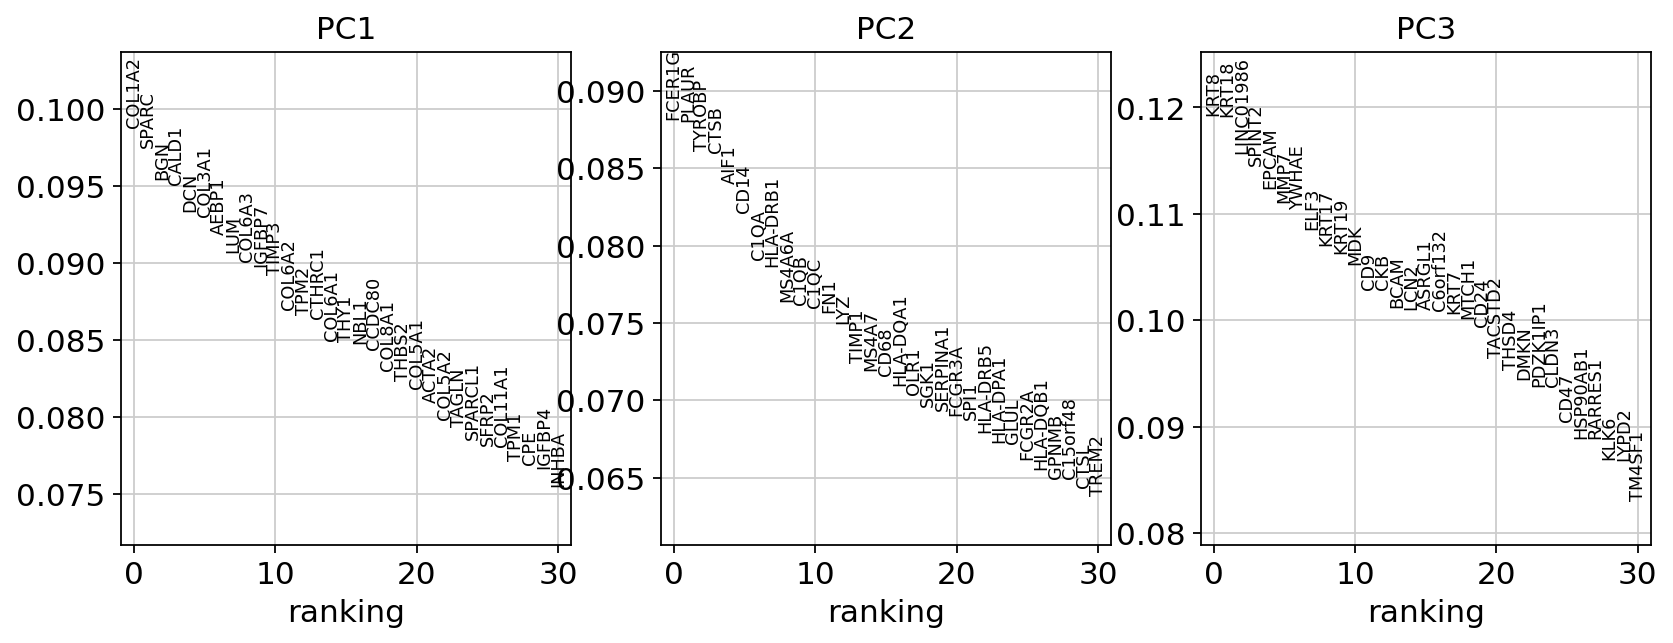

In [34]:
sc.pl.pca_loadings(all_adata, include_lowest=False)


## Compute and embed neighborhood graph

In [35]:
# valculate neighborhood graph
sc.pp.neighbors(all_adata)

# make umap
sc.tl.umap(all_adata)


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:09)


## Cluster the neighborhood graph

running Leiden clustering


/tmp/ipykernel_2355973/2557792080.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(all_adata, resolution=0.7)


    finished: found 25 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:05)


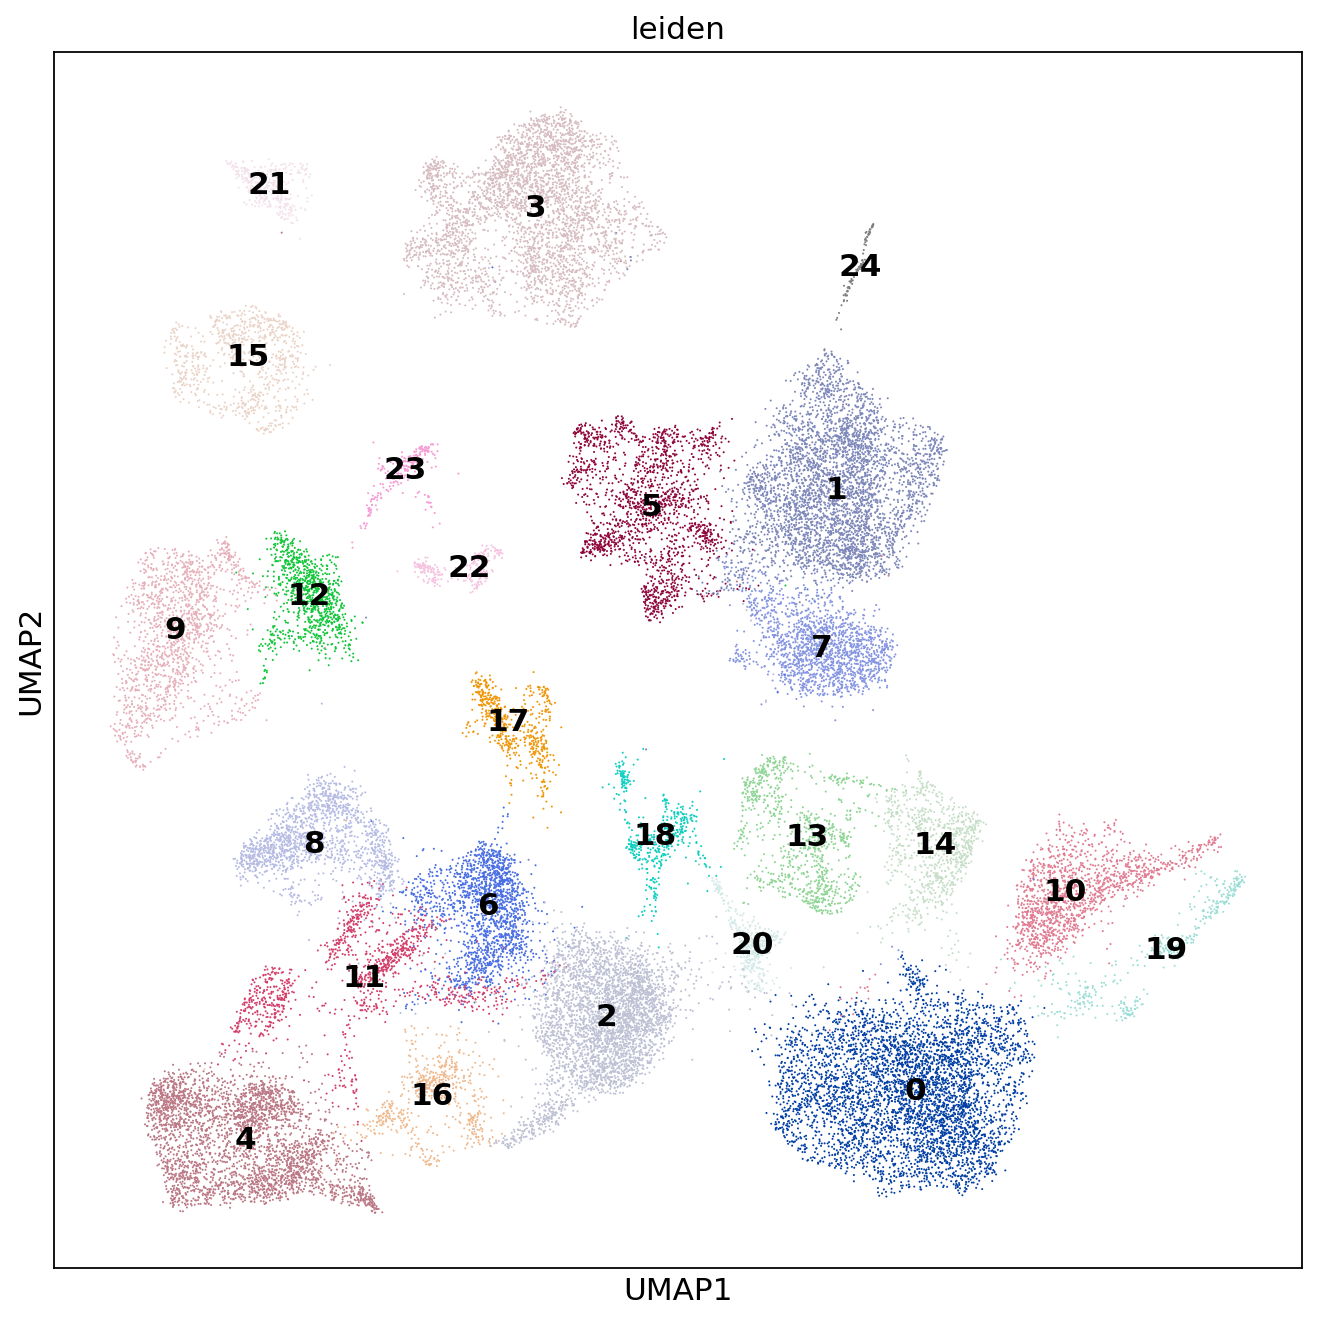

In [36]:
# lets use Leiden clustering
sc.tl.leiden(all_adata, resolution=0.7)
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(all_adata, color='leiden', legend_loc='on data')



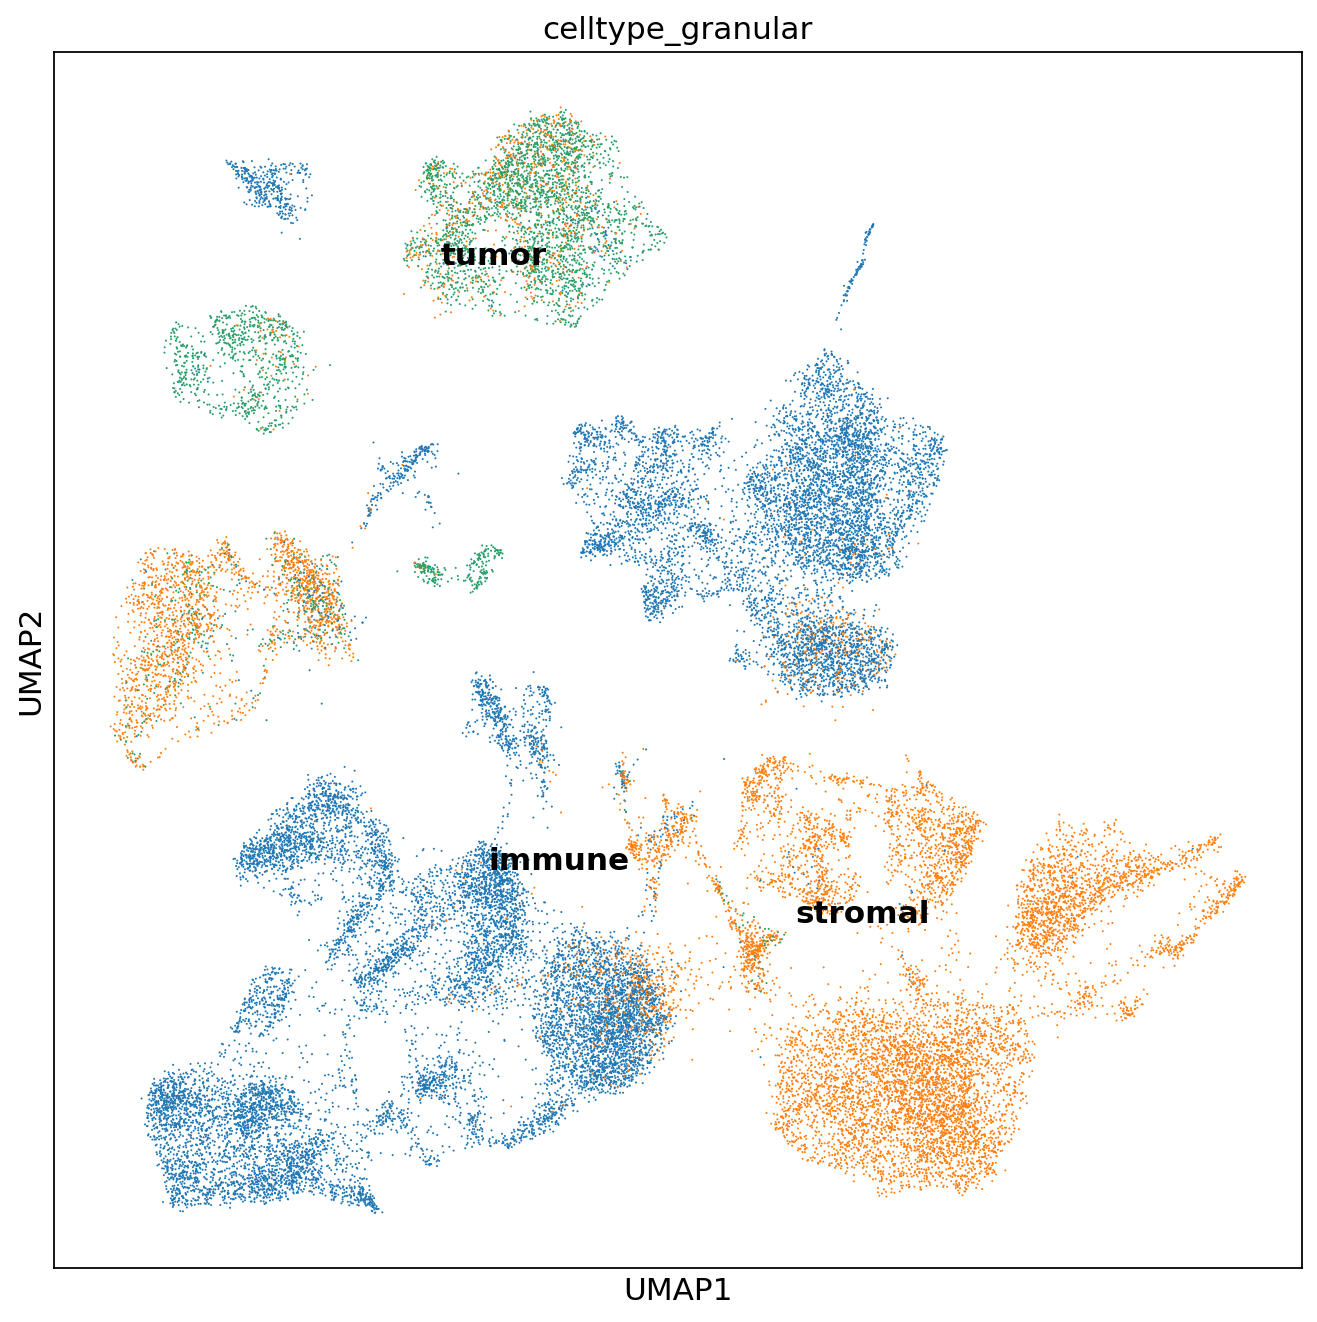

In [37]:
# lets use previously identified clustering
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(all_adata, color='celltype_granular', legend_loc='on data')


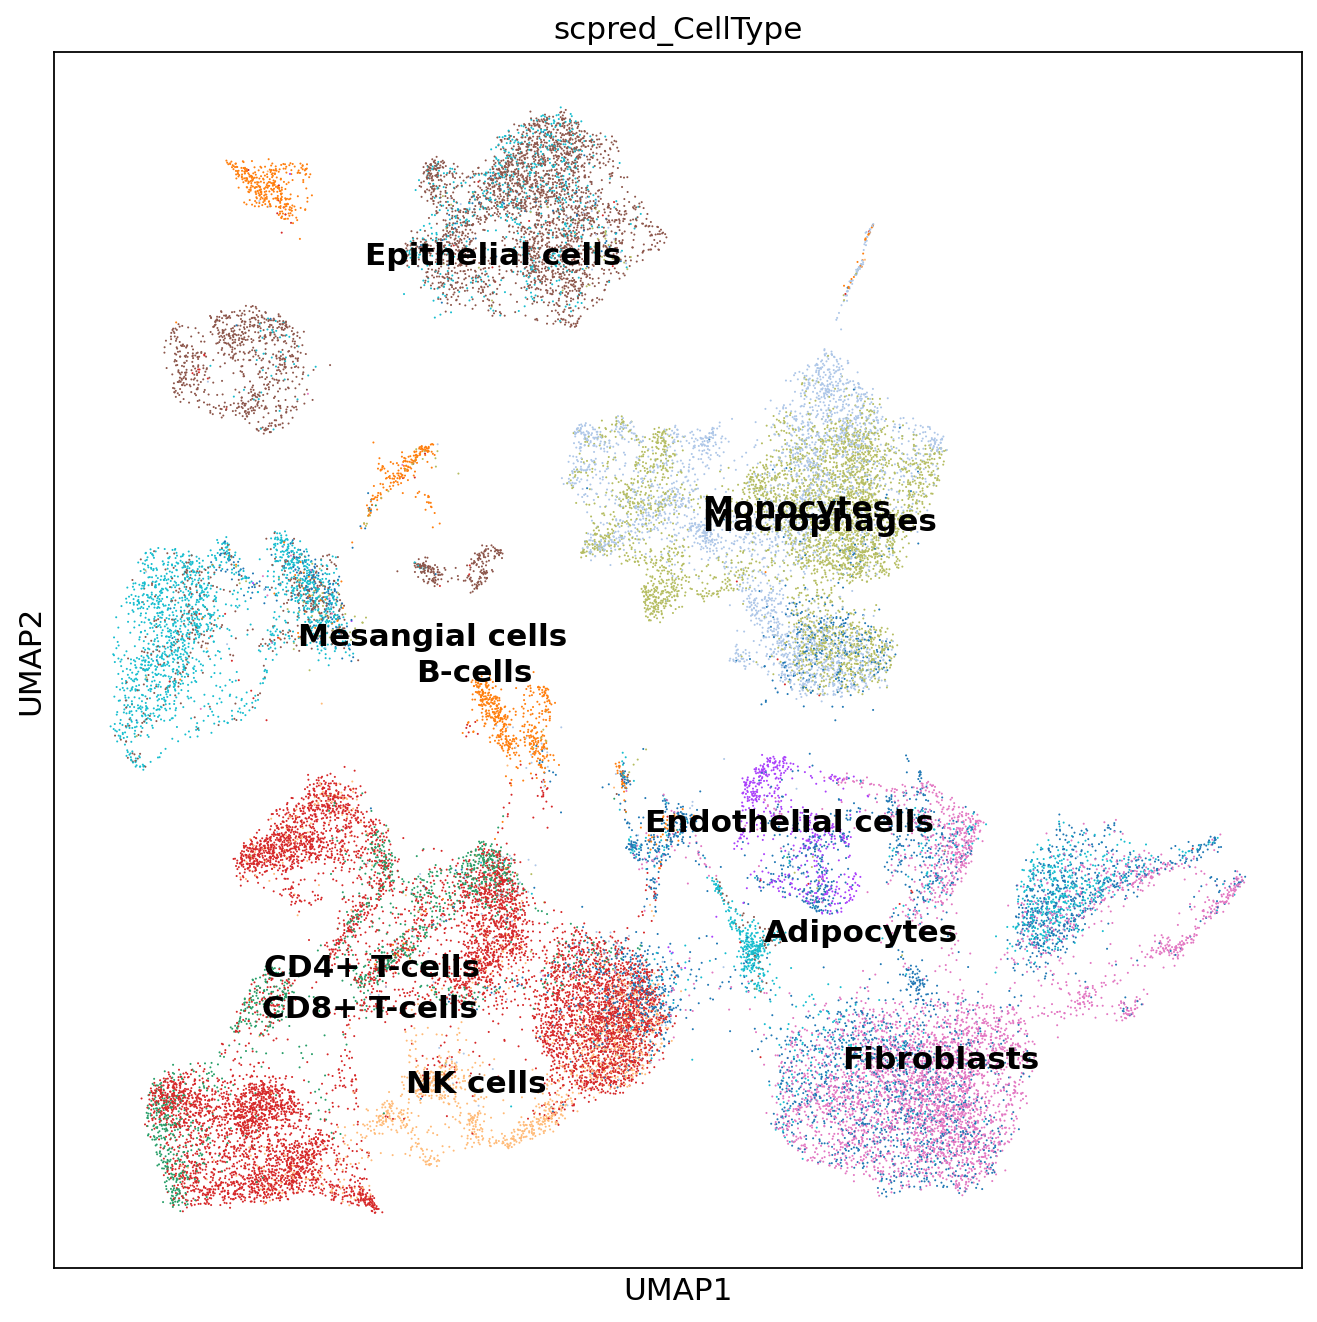

In [38]:
# lets use previously identified clustering
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(all_adata, color='scpred_CellType', legend_loc='on data')


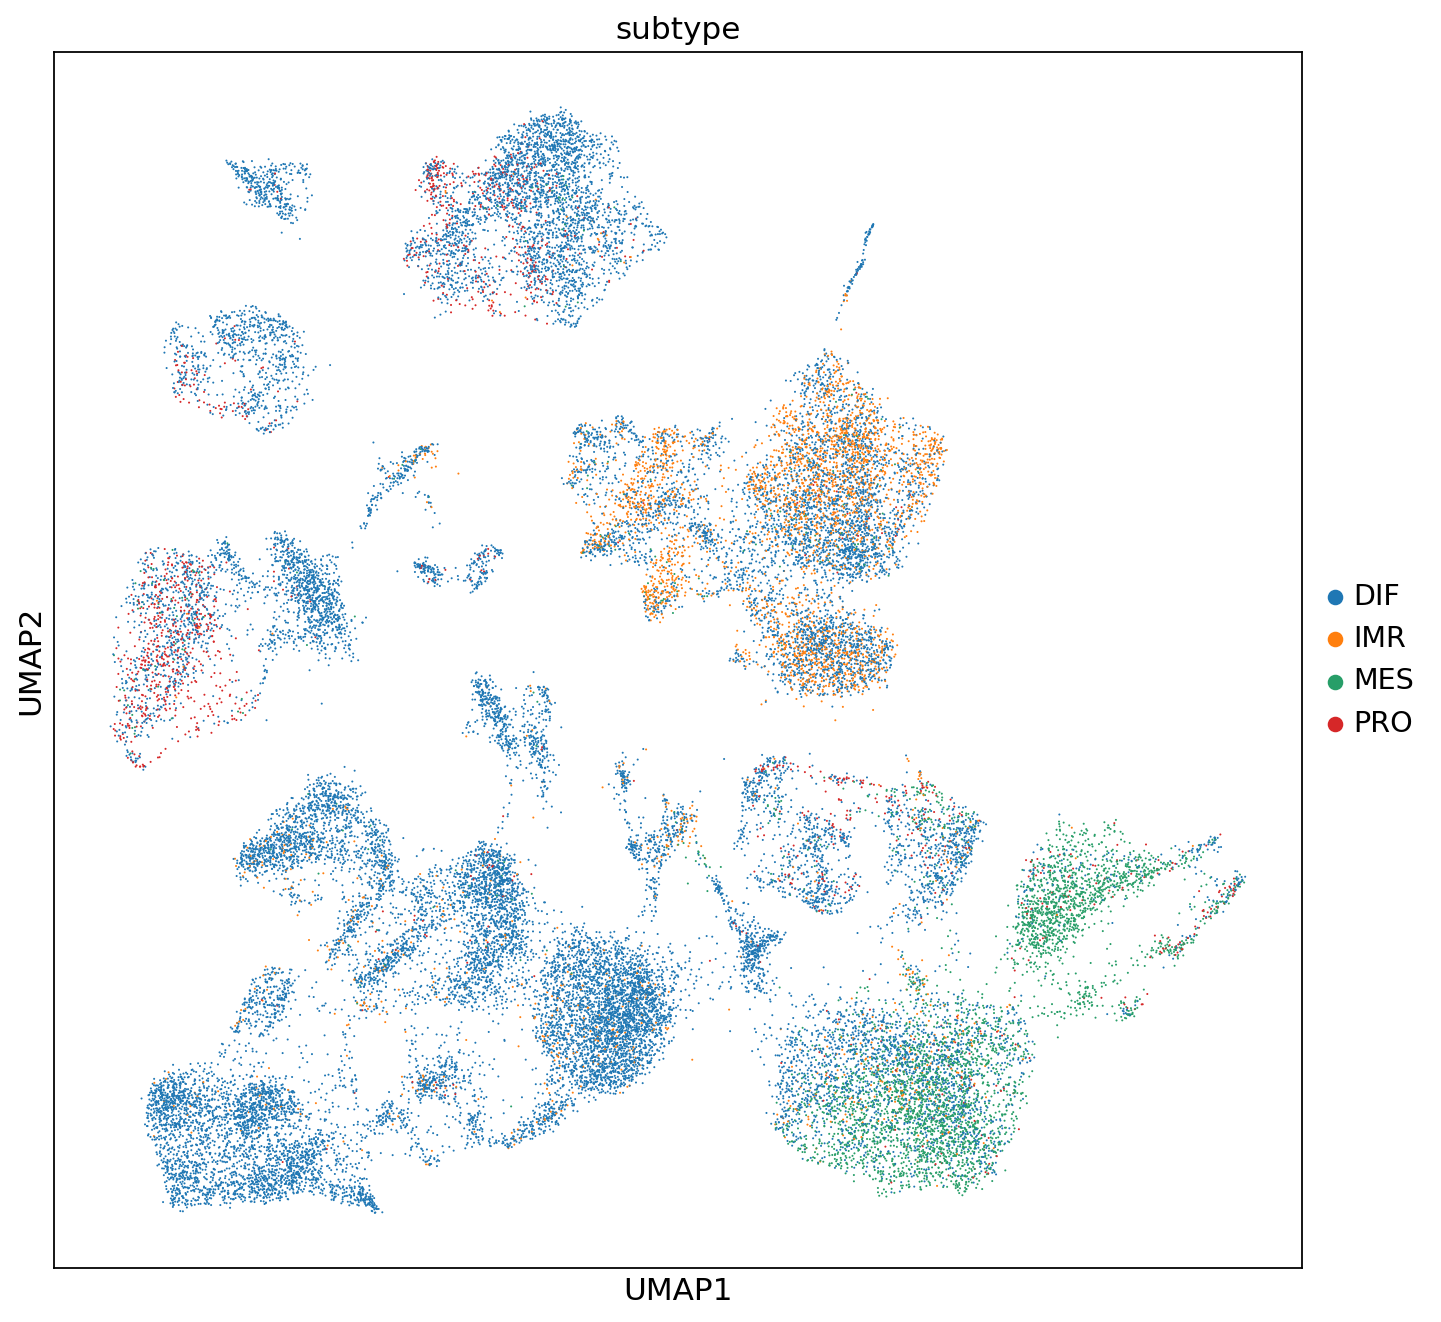

In [39]:
# lets use previously identified clustering
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(all_adata, color='subtype')


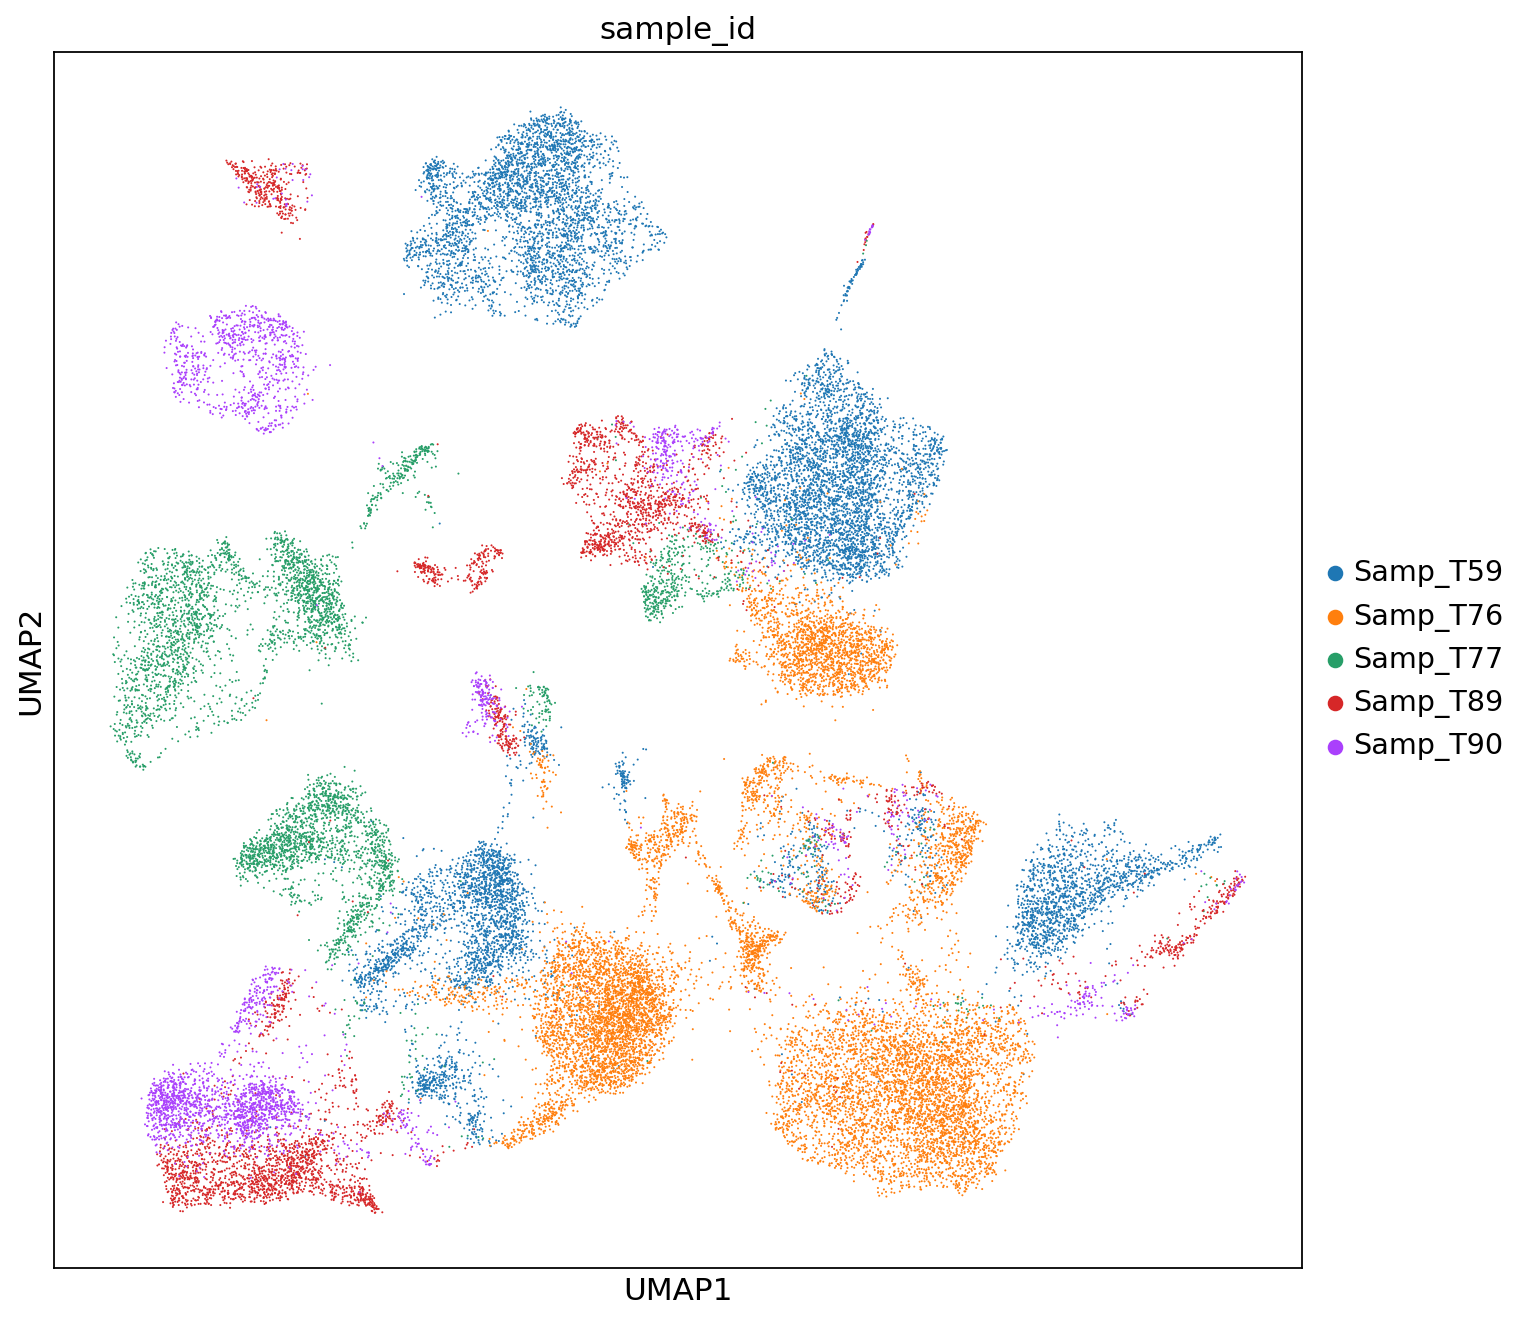

In [40]:
# plot by sample id
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(all_adata, color='sample_id')


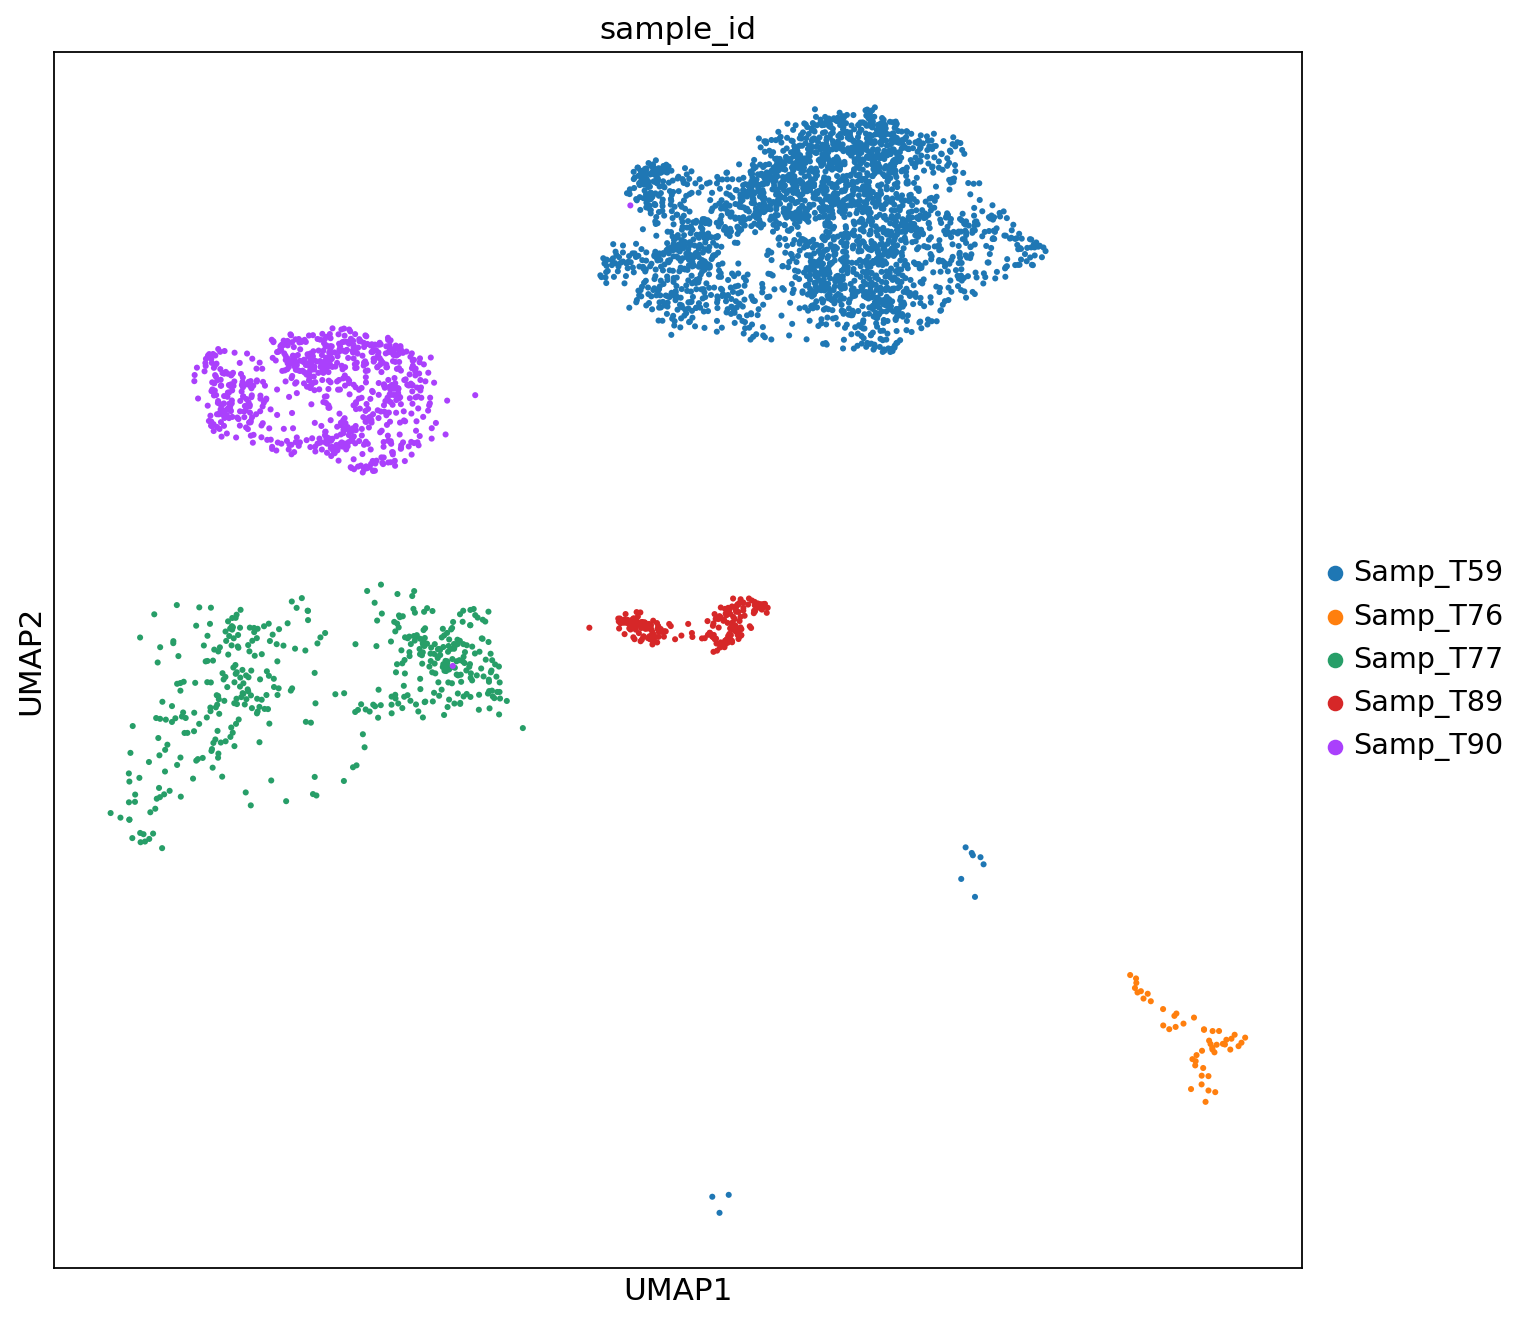

In [41]:
# plot by sample id
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(all_adata[np.where(all_adata.obs.celltype_granular == "tumor")[0]], color='sample_id')
